In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Import

In [0]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
features_df = pd.read_csv("/content/drive/My Drive/DMBI_Proj/Data/features.csv",parse_dates=['Date'],date_parser=dateparse)
stores_df = pd.read_csv("/content/drive/My Drive/DMBI_Proj/Data/stores.csv")
test_df = pd.read_csv("/content/drive/My Drive/DMBI_Proj/Data/test.csv",parse_dates=['Date'], date_parser=dateparse)
train_df = pd.read_csv("/content/drive/My Drive/DMBI_Proj/Data/train.csv",parse_dates=['Date'],date_parser=dateparse)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


# EDA & Data Cleaning

In [0]:
train_model_df = pd.merge(train_df, stores_df, on='Store', how='inner')
train_model_df = pd.merge(train_model_df, 
                       features_df,
                       on=['Store', 'Date','IsHoliday'],
                       how='inner')

test_model_df = pd.merge(test_df, stores_df, on='Store', how='inner')
test_model_df = pd.merge(test_model_df, 
                       features_df,
                       on=['Store', 'Date','IsHoliday'],
                       how='inner')

#train_model_df.Date = pd.to_datetime(train_model_df.Date)
#test_model_df.Date = pd.to_datetime(test_model_df.Date)

In [0]:
train_model_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [0]:
train_model_df.shape

(421570, 16)

In [0]:
train_model_df.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In [0]:
pd.DataFrame(100*(train_model_df.isnull().sum()/train_model_df.shape[0])).rename(columns={0:'Percentual of Missing Values (%)'})

,Percentual of Missing Values (%)
Store,0.000000
Dept,0.000000
Date,0.000000
Weekly_Sales,0.000000
IsHoliday,0.000000
Type,0.000000
Size,0.000000
Temperature,0.000000
Fuel_Price,0.000000
MarkDown1,64.257181


Markdown features have missing value of around 65-70%. We will look into correlation matrix and if it is not significant we will drop them

In [0]:
train_model_df.groupby(['Store','Dept'])['Date'].count().reset_index().set_index(['Store','Dept']).describe()

,Date
count,3331.000000
mean,126.559592
std,40.212763
min,1.000000
25%,143.000000
50%,143.000000
75%,143.000000
max,143.000000


In [0]:
df_temp = train_model_df.groupby(['Store','Dept'])['Date'].count().reset_index().set_index(['Store','Dept'])
df_temp[df_temp['Date'] !=143]

Date
Store Dept      
1     18     113
      45      71
      47      22
      48     125
      51      33
...          ...
45    78       8
      80     130
      94     134
      96       2
      98     135

[671 rows x 1 columns]

So we do not have data for all departments. We can see we have minimum of 1 value impying there is atleast one department with only one week of data. This is an important finding on how to group our data on department and store level to avoid accidental biasing. We will take average while rolling up our data on store and department levels.

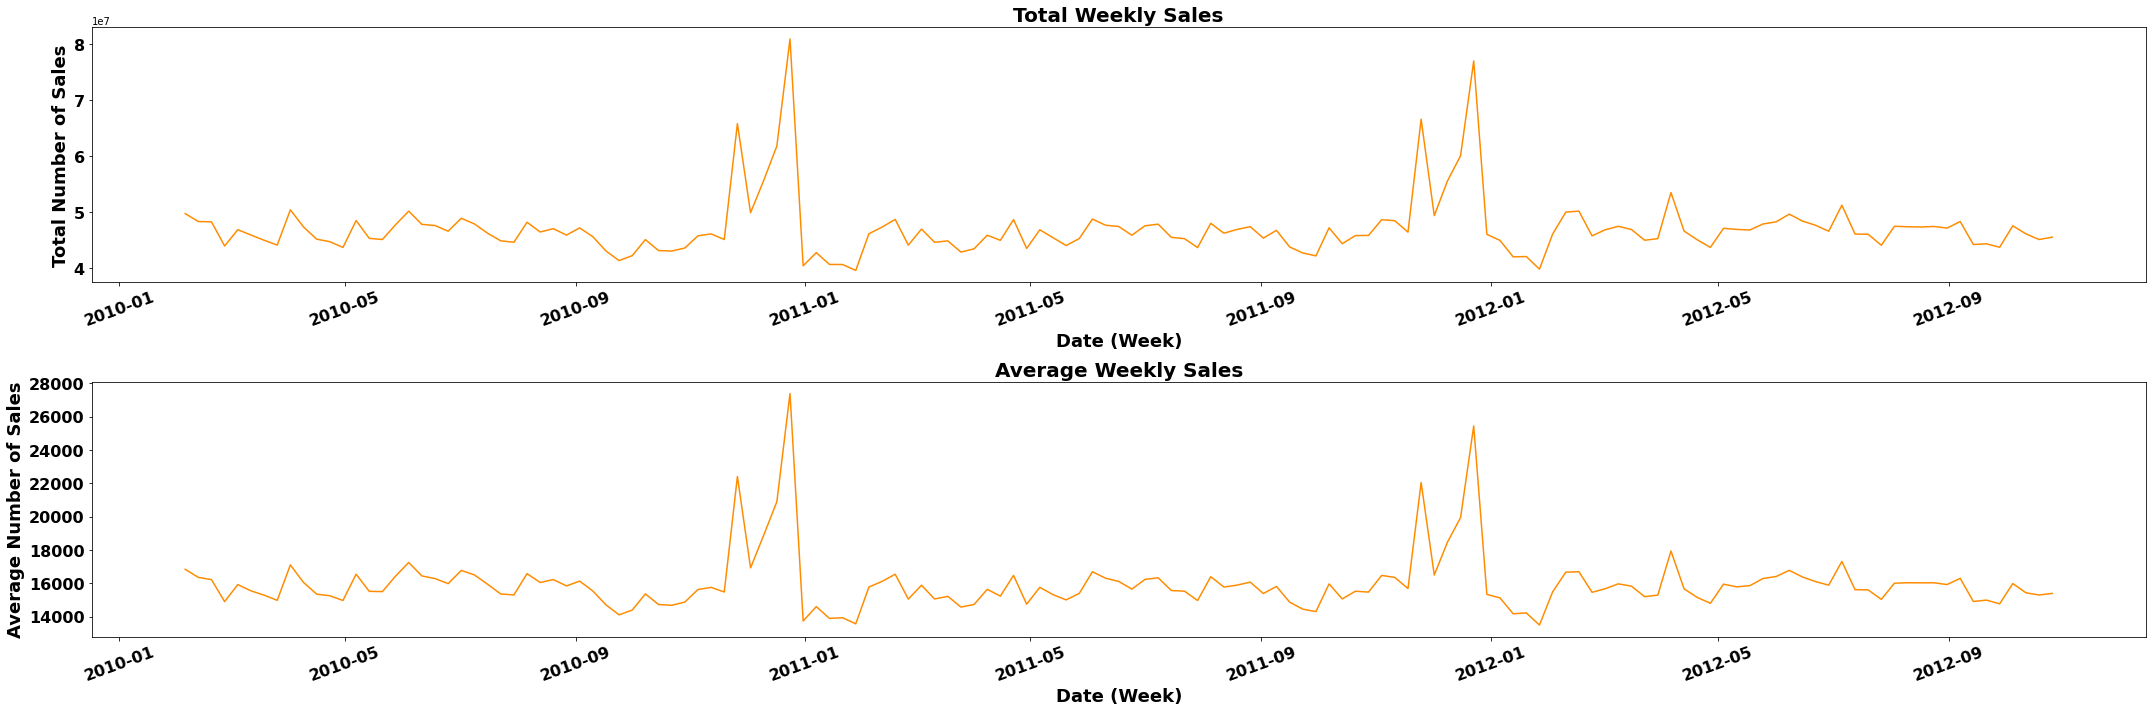

In [0]:
plt.figure(figsize=(30,10));

plt.subplot(2,1,1);
weekly_plot = train_model_df.sort_values(by='Date',ascending=True).groupby('Date')['Weekly_Sales'].sum().reset_index();
weekly_plot['Date'] = pd.to_datetime(weekly_plot['Date']);
sns.lineplot(x="Date", y="Weekly_Sales", markers=True, dashes=False, data=weekly_plot, color='darkorange');
plt.title("Total Weekly Sales", fontsize=20, fontweight="bold");
plt.xticks(rotation=20, fontweight='bold', fontsize=16);
plt.yticks(fontweight='bold', fontsize=16);
plt.xlabel("Date (Week)", fontsize=18, fontweight='bold');
plt.ylabel("Total Number of Sales", fontsize=18, fontweight='bold');

plt.subplot(2,1,2);
weekly_plot = train_model_df.sort_values(by='Date',ascending=True).groupby('Date')['Weekly_Sales'].mean().reset_index();
weekly_plot['Date'] = pd.to_datetime(weekly_plot['Date']);
sns.lineplot(x="Date", y="Weekly_Sales", markers=True, dashes=False, data=weekly_plot, color='darkorange');
plt.title("Average Weekly Sales", fontsize=20, fontweight="bold");
plt.xticks(rotation=20, fontweight='bold', fontsize=16);
plt.yticks(fontweight='bold', fontsize=16);
plt.xlabel("Date (Week)", fontsize=18, fontweight='bold');
plt.ylabel("Average Number of Sales", fontsize=18, fontweight='bold');

plt.tight_layout()

## Observing Seasonality

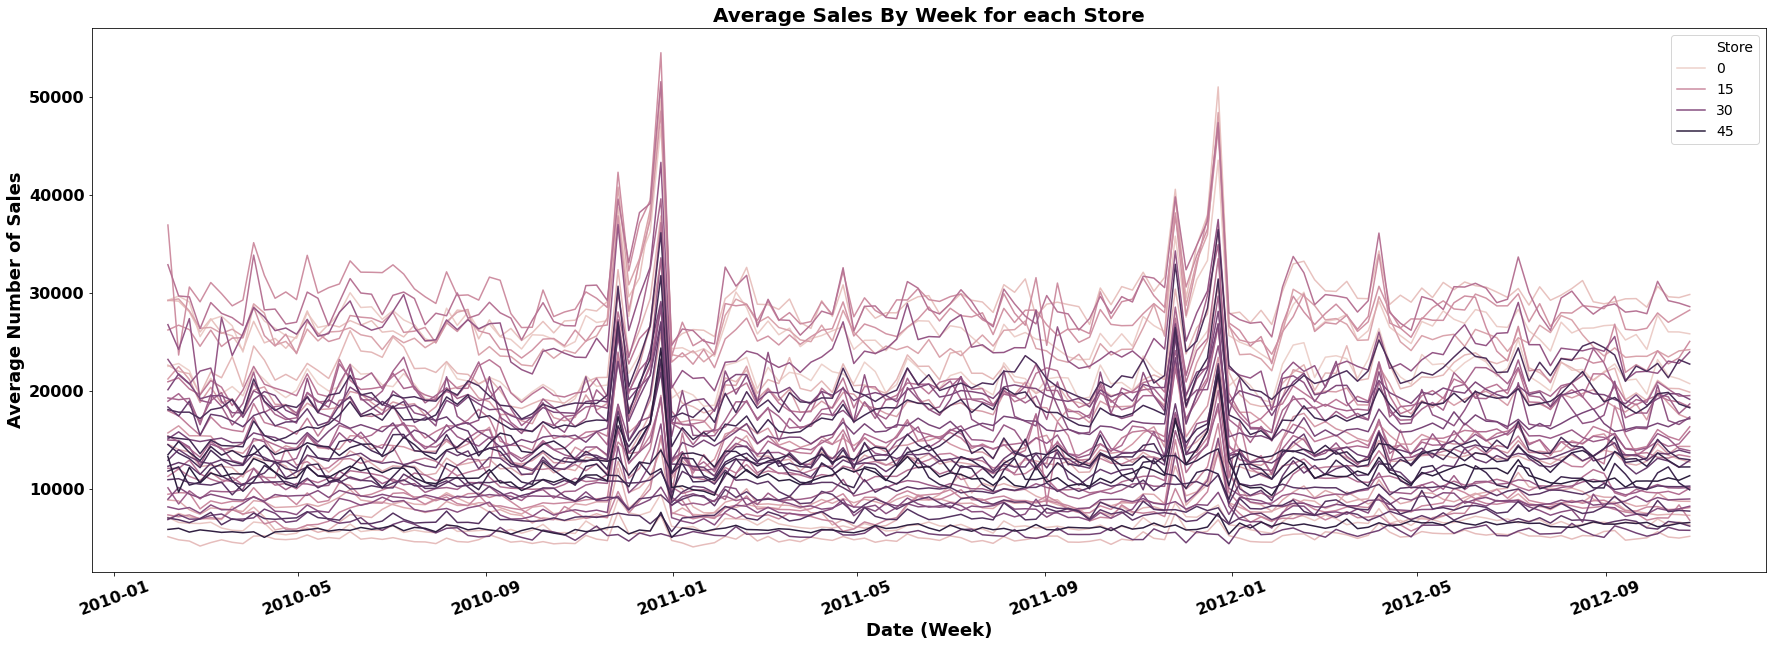

In [0]:
plt.figure(figsize=(30,10));
weekly_store_plot = train_model_df.sort_values(by='Date',ascending=True).groupby(['Date','Store'])['Weekly_Sales'].mean().reset_index();
weekly_store_plot['Date'] = pd.to_datetime(weekly_store_plot['Date']);

sns.lineplot(x="Date", y="Weekly_Sales",hue='Store', markers=True, dashes=False, data=weekly_store_plot);
plt.title("Average Sales By Week for each Store", fontsize=20, fontweight="bold");
plt.xticks(rotation=20, fontweight='bold', fontsize=16);
plt.yticks(fontweight='bold', fontsize=16);
plt.legend(fontsize=14);
plt.xlabel("Date (Week)", fontsize=18, fontweight='bold');
plt.ylabel("Average Number of Sales", fontsize=18, fontweight='bold');

There is clearly seasonality in our dataset. This is directly in relation to field marked as IsHoliday. Important thing to notice is that the effect of one holiday may last in just one week or in multiple week. Reason being, the elongated effect is seen around a holiday and we dont know how many pre and post holiday day that week has.

If, for a certain Week, there are more pre-holiday days in one Year than another, then it is very possible that the Year with more pre-holiday days will have greater Sales for the same Week. So, the model will not take this consideration and we might need to adjust the predicted values at the end.

For this reason, I will be adding for each holiday 4 additional days: 2 before and 2 after the holiday's original date. (This is done in the function create_holidays).

## Updating Holiday

In [0]:
def create_holidays(x):
    """
    This function defines each holiday based on its corresponding dates.
    Notice that 4 additional days are included for each holiday: 2 days before
    and 2 days after the original date.
    
    Arguments:
        x: an input date
    
    Output:
        the corresponding date
    """
    if x in ['2010-02-10','2010-02-11','2010-02-12','2010-02-13','2010-02-14',
             '2011-02-09','2011-02-10','2011-02-11','2011-02-12','2011-02-13',
             '2012-02-08','2012-02-09','2012-02-10','2012-02-11','2012-02-12',
             '2013-02-06','2013-02-07','2013-02-08','2013-02-09','2013-02-10']:
        
        return 'super_bowl'
    
    elif x in ['2010-09-08','2010-09-09','2010-09-10','2010-09-11','2010-09-12',
               '2011-09-09','2011-09-10','2011-09-11','2011-09-12','2011-09-13',
               '2012-09-05','2012-09-06','2012-09-07','2012-09-08','2012-09-09',
               '2013-09-04','2013-09-05','2013-09-06','2013-09-07','2013-09-08']:
        
        return 'labor_day'
    
    elif x in ['2010-11-24','2010-11-25','2010-11-26','2010-11-27','2010-11-28',
               '2011-11-23','2011-11-24','2011-11-25','2011-11-26','2011-11-27',
               '2012-11-21','2012-11-22','2012-11-23','2012-11-24','2012-11-25',
               '2013-11-27','2013-11-28','2013-11-29','2013-11-30','2013-12-01']:
        
        return 'thanksgiving'
    
    elif x in ['2010-12-29','2010-12-30','2010-12-31','2010-12-31','2010-12-31',
               '2011-12-30','2011-12-30','2011-12-30','2011-12-30','2011-12-30',
               '2012-12-28','2012-12-28','2012-12-28','2012-12-28','2012-12-28',
               '2013-12-27','2013-12-27','2013-12-27','2013-12-27','2013-12-27']:
        
        return 'christmas'

In [0]:
def update_isholiday(x):
    """
    This function is used for update the IsHoliday field
    from the original dataframe.
    
    Arguments:
        x: a holiday produced by the function create_holidays
    
    Output:
        1 if a holiday, 0 otherwise.
    """
    if x is not None:
        return 1
    else:
        return 0

In [0]:
train_model_df['holiday'] = train_model_df['Date'].apply(create_holidays)
train_model_df['IsHoliday'] = train_model_df['holiday'].apply(update_isholiday)

test_model_df['holiday'] = test_model_df['Date'].apply(create_holidays)
test_model_df['IsHoliday'] = test_model_df['holiday'].apply(update_isholiday)

In [0]:
train_model_df[train_model_df['IsHoliday']==1].head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,holiday


## Outliers

In [0]:
outliers_df = train_model_df[train_model_df['IsHoliday']==0]

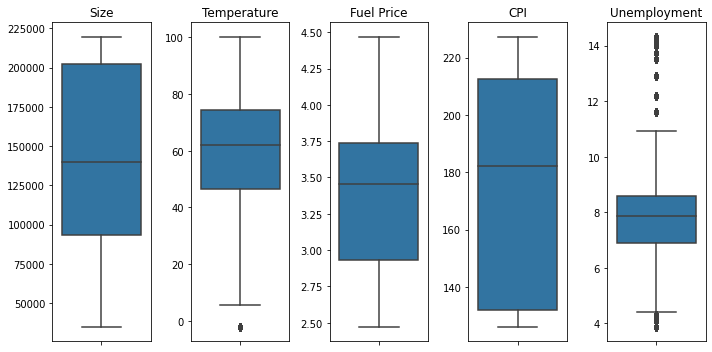

In [0]:
plt.figure(figsize=(10,5));

plt.subplot(1,5,1);
sns.boxplot(x=outliers_df["Size"].values, orient='v');
plt.title("Size");
plt.subplot(1,5,2);
sns.boxplot(x=outliers_df["Temperature"].values, orient='v');
plt.title("Temperature");
plt.subplot(1,5,3);
sns.boxplot(x=outliers_df["Fuel_Price"].values, orient='v');
plt.title("Fuel Price");
plt.subplot(1,5,4);
sns.boxplot(x=outliers_df["CPI"].values, orient='v');
plt.title("CPI");
plt.subplot(1,5,5);
sns.boxplot(x=outliers_df["Unemployment"].values, orient='v');
plt.title("Unemployment");

plt.tight_layout()

There is aparantely no outliers, that needs speacial attention

## Correlation

Correlation Metrics:
*   0: no correlation at all
*   0-0.3: weak correlation
*   0.3-0.7: moderate correlaton
*   0.7-1: strong correlation

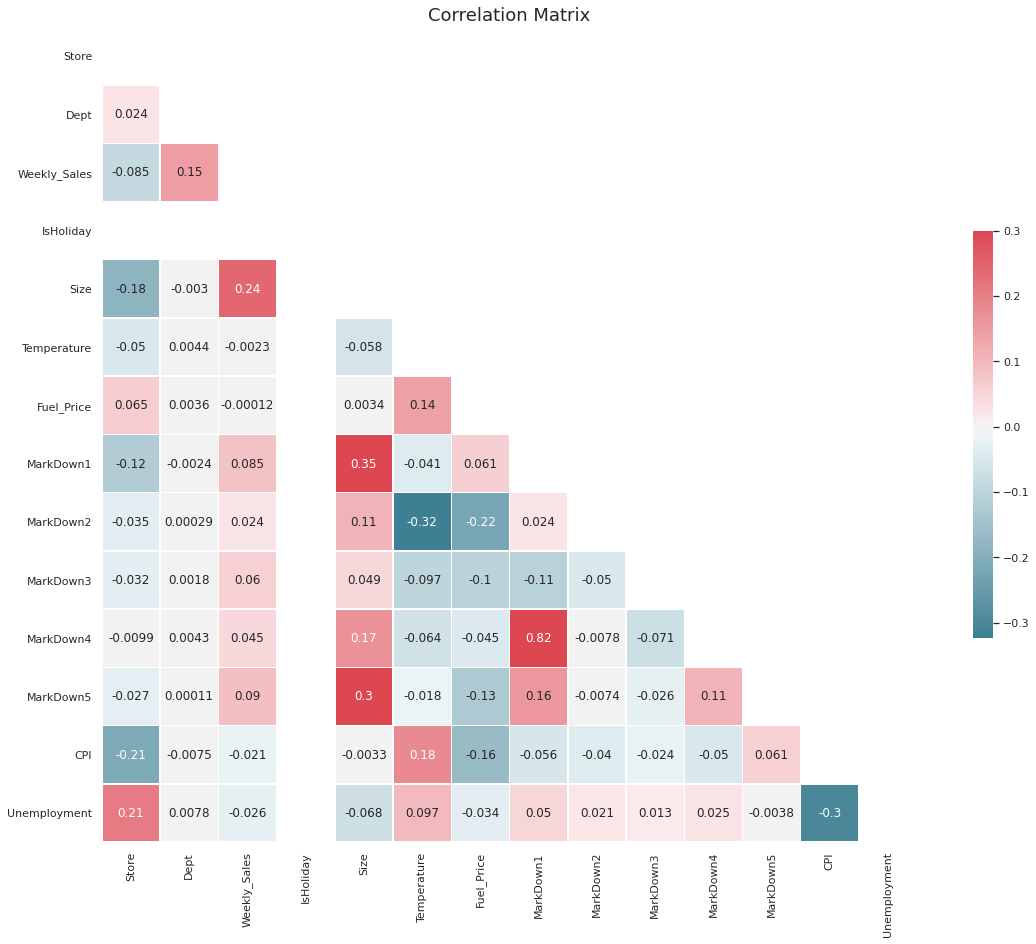

In [0]:
sns.set(style="white")

corr = train_model_df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

'MarkDown' 1 to 5 are not strong correlated to 'Weekly_Sales' and they have a lot of null values, then we can drop them.

only dept, size and is Holiday have considerable correlation so wel will keep it dropping others (we will use them as a regressor for our SARIMA) 

In [0]:
train_model_df = train_model_df.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5', 'CPI','Unemployment', 'Fuel_Price', 'Temperature', 'holiday'])
test_model_df = test_model_df.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5', 'CPI', 'Unemployment' , 'Fuel_Price', 'Temperature', 'holiday'])

In [0]:
train_model_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,0,A,151315
1,1,2,2010-02-05,50605.27,0,A,151315
2,1,3,2010-02-05,13740.12,0,A,151315
3,1,4,2010-02-05,39954.04,0,A,151315
4,1,5,2010-02-05,32229.38,0,A,151315


In [0]:
test_model_df.head()

,Store,Dept,Date,IsHoliday,Type,Size
0,1,1,2012-11-02,0,A,151315
1,1,2,2012-11-02,0,A,151315
2,1,3,2012-11-02,0,A,151315
3,1,4,2012-11-02,0,A,151315
4,1,5,2012-11-02,0,A,151315


## Level of Modeling

We have data at store and department level. We will model it for one store and department combination and same steps can be replicated for others stores and departments.

Let's plot store and department level to select which one can be selected for modeling

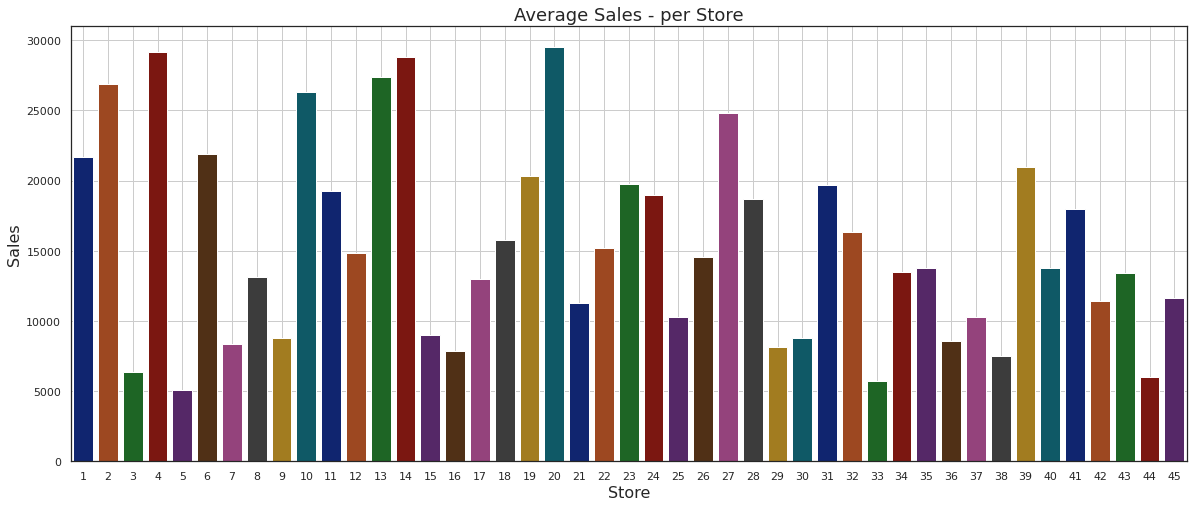

In [0]:
weekly_sales = train_model_df['Weekly_Sales'].groupby(train_model_df['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

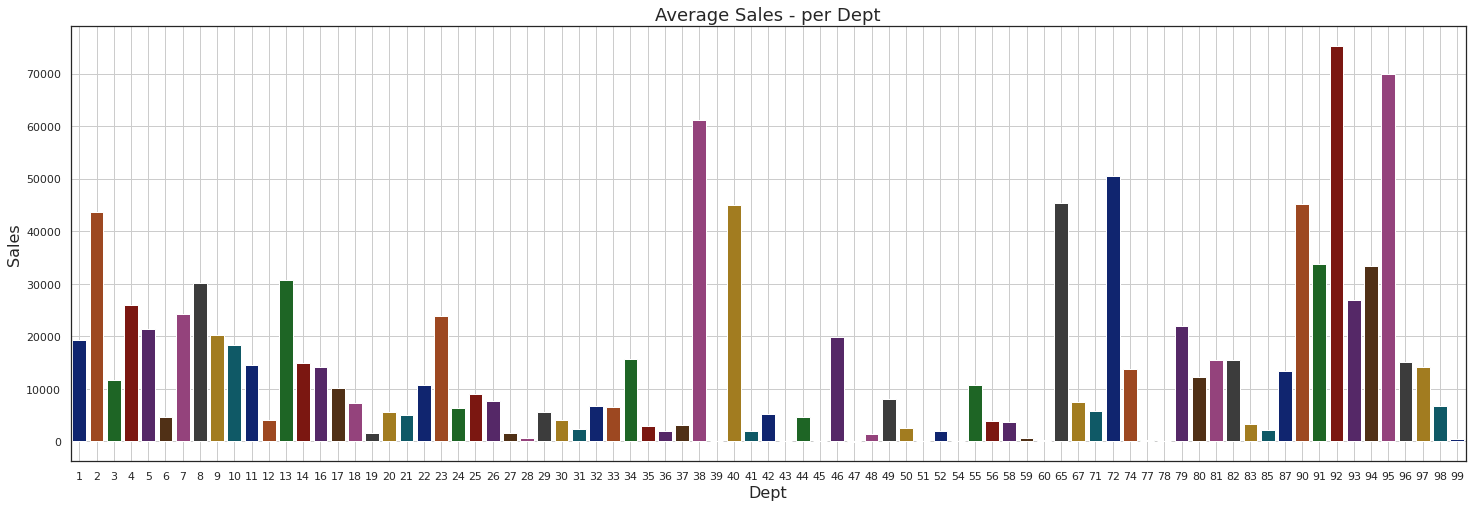

In [0]:
weekly_sales = train_model_df['Weekly_Sales'].groupby(train_model_df['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

Let's model for Store = 20 and Dept = 92 (max Values)

In [0]:
dfTemp = train_model_df[train_model_df['Store']==20]
print( dfTemp[dfTemp['Dept']==92])

        Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size
187402     20    92 2010-02-05     195223.84          0    A  203742
187473     20    92 2010-02-12     170043.55          0    A  203742
187546     20    92 2010-02-19     164314.29          0    A  203742
187618     20    92 2010-02-26     147699.66          0    A  203742
187690     20    92 2010-03-05     169171.18          0    A  203742
...       ...   ...        ...           ...        ...  ...     ...
197256     20    92 2012-09-28     158539.12          0    A  203742
197327     20    92 2012-10-05     187027.05          0    A  203742
197401     20    92 2012-10-12     191136.10          0    A  203742
197472     20    92 2012-10-19     171537.94          0    A  203742
197543     20    92 2012-10-26     160785.98          0    A  203742

[143 rows x 7 columns]


## Train, Val & Test

In [0]:
import math


modeling_df = train_model_df[train_model_df['Store']==20]
modeling_df = modeling_df[modeling_df['Dept']==92]
modeling_df.set_index('Date', inplace=True, drop=True)

len_Total =modeling_df.shape[0]
len_train = math.ceil(0.8*len_Total)
len_Val = len_Total - len_train

modeling_df_train = modeling_df.iloc[:len_train]
modeling_df_Val = modeling_df.iloc[len_train:]

modeling_df_test = test_model_df[test_model_df['Store']==20]
modeling_df_test = modeling_df_test[modeling_df_test['Dept']==92]
modeling_df_test.set_index('Date', inplace=True, drop=True)
modeling_df_train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size
Date,,,,,,
2010-02-05,20,92,195223.84,0,A,203742
2010-02-12,20,92,170043.55,0,A,203742
2010-02-19,20,92,164314.29,0,A,203742
2010-02-26,20,92,147699.66,0,A,203742
2010-03-05,20,92,169171.18,0,A,203742


## Trend Decomposition

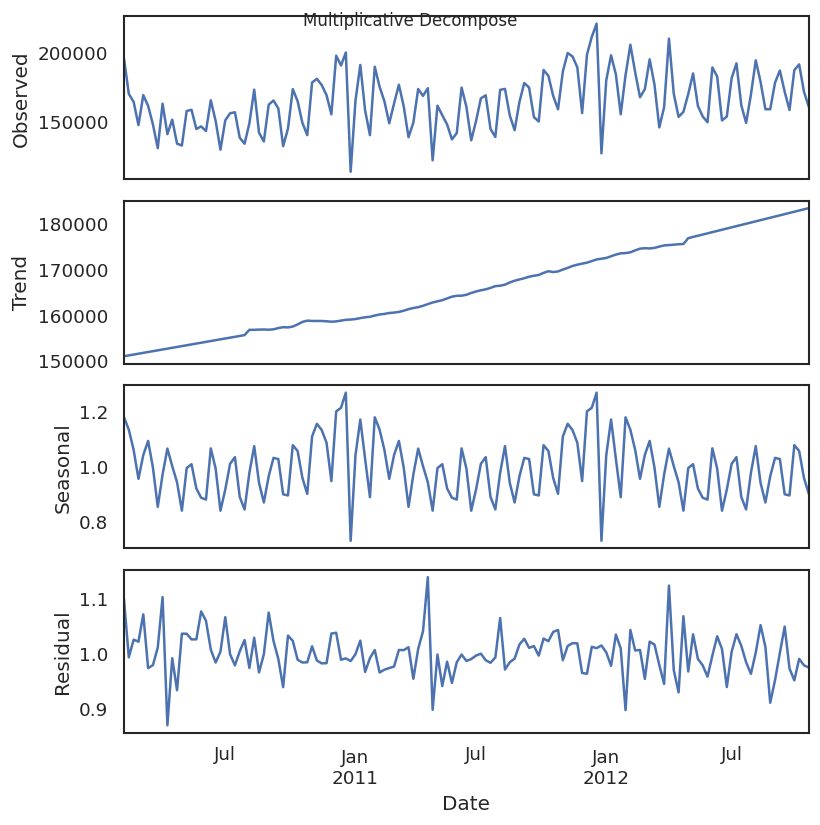

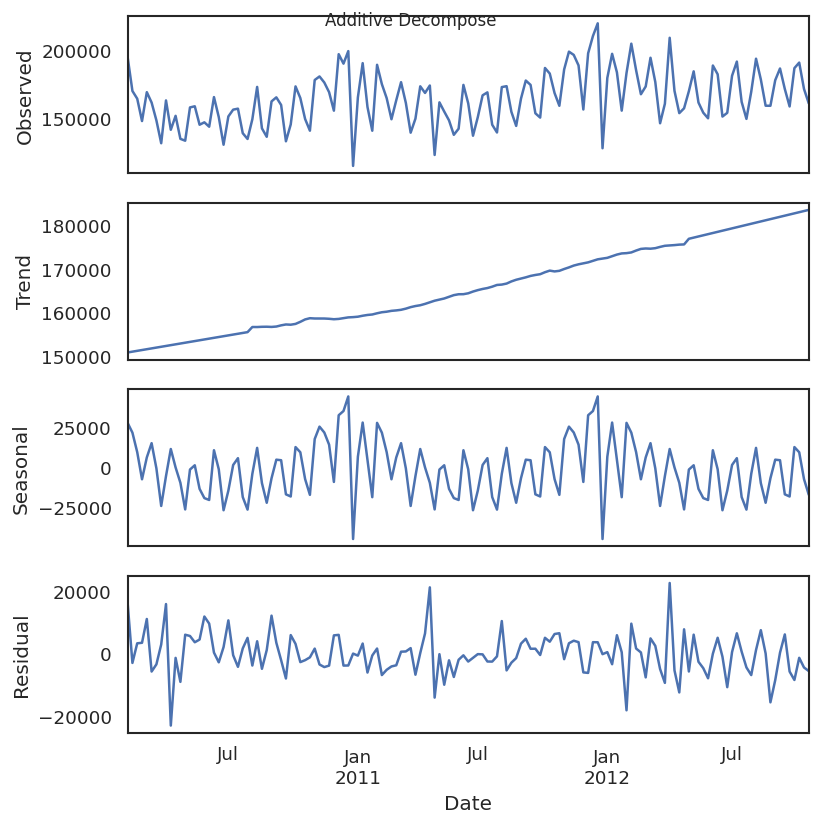

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
result_mul = seasonal_decompose(modeling_df['Weekly_Sales'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(modeling_df['Weekly_Sales'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (7,7)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=10)
result_add.plot().suptitle('Additive Decompose', fontsize=10)
plt.tight_layout()
plt.show()

# Modeling (Store + Dept level)

## Seasonality 

We already know our series have seasonality but let's observe ACF plot to confirm this

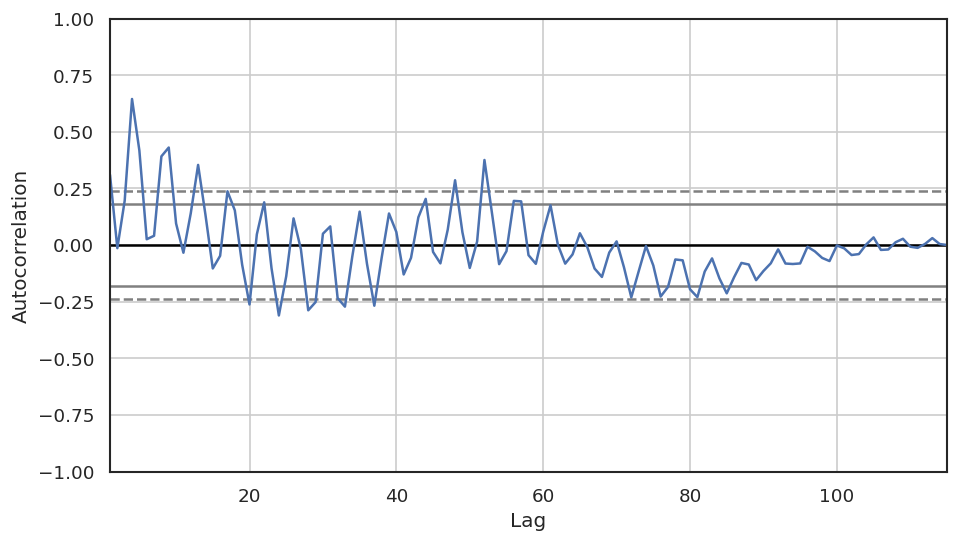

In [0]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(modeling_df_train.Weekly_Sales.tolist())

The regular ups and downs suggest strong seasonality in data

## Stationarity Check (d)

In [0]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test ( for stationary series p value should be less than 0.5 - H0: Non stationary) 
result = adfuller(modeling_df_train.Weekly_Sales.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


# KPSS Test (for stationary series p value should be greater than 0.5 - H0: Stationary)
result = kpss(modeling_df_train.Weekly_Sales.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.4349308214838088
p-value: 0.565420070639964
Critial Values:
   1%, -3.4912451337340342
Critial Values:
   5%, -2.8881954545454547
Critial Values:
   10%, -2.5809876033057852

KPSS Statistic: 0.498387
p-value: 0.042030
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


This says that series is non stationary for given store and department

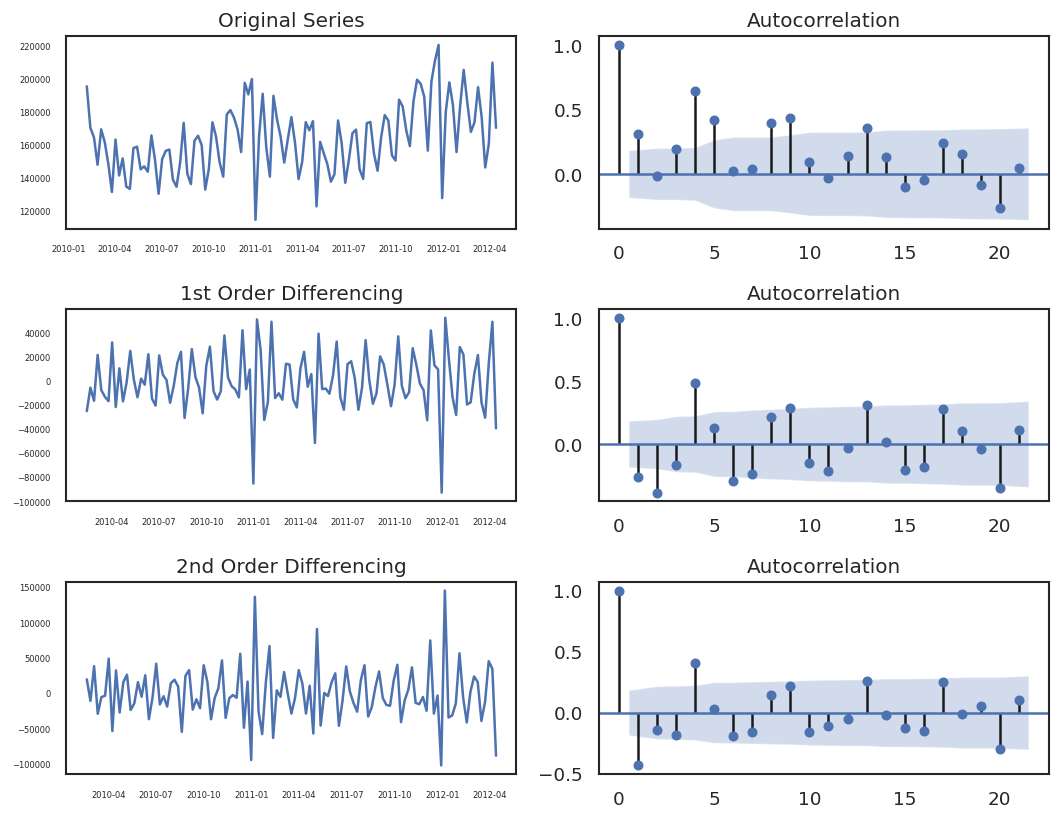

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.ticker as ticker
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)# , sharex=True)
axes[0, 0].plot(modeling_df_train.Weekly_Sales); axes[0, 0].set_title('Original Series')
# axes[0, 0].xaxis.set_major_formatter(ticker.EngFormatter())
# axes[0, 0].set_xlim([730000, 740000])
axes[0, 0].tick_params(axis='both', which='major', labelsize=5)
plot_acf(modeling_df_train.Weekly_Sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(modeling_df_train.Weekly_Sales.diff()); axes[1, 0].set_title('1st Order Differencing')
# axes[1, 0].xaxis.set_major_formatter(ticker.EngFormatter())
axes[1, 0].tick_params(axis='both', which='major', labelsize=5)
plot_acf(modeling_df_train.Weekly_Sales.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(modeling_df_train.Weekly_Sales.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
# axes[2, 0].xaxis.set_major_formatter(ticker.EngFormatter())
axes[2, 0].tick_params(axis='both', which='major', labelsize=5)
plot_acf(modeling_df_train.Weekly_Sales.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()
plt.show()


For difference of 1 our series is over differenced (auto correlation jumps to -ve). So to balance things out we will put additional MA factor in ARIMA modeling

d = 1

## AR Order (p)

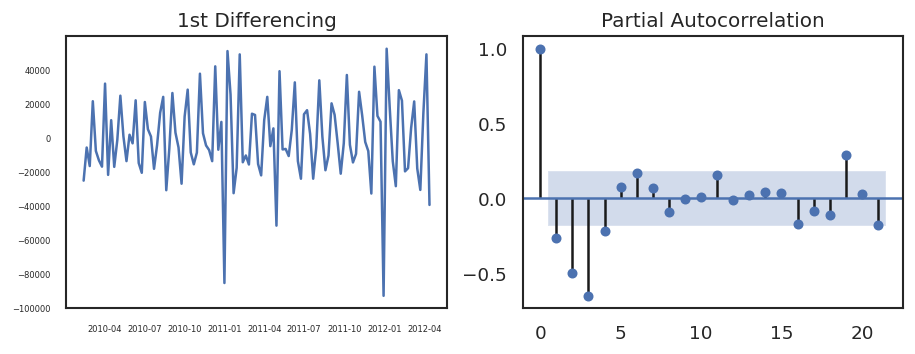

In [0]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)#, sharex=True)
axes[0].plot(modeling_df_train.Weekly_Sales.diff()); axes[0].set_title('1st Differencing')
# axes[0].xaxis.set_major_formatter(ticker.EngFormatter())
axes[0].tick_params(axis='both', which='major', labelsize=5)
plot_pacf(modeling_df_train.Weekly_Sales.diff().dropna(), ax=axes[1])

plt.show()

Given the above PACF graph lag 1 is slightly above confidence interval. we can go ahead with p = 0 if we want to be more conservative else p = 1 may work

## MA order (q)

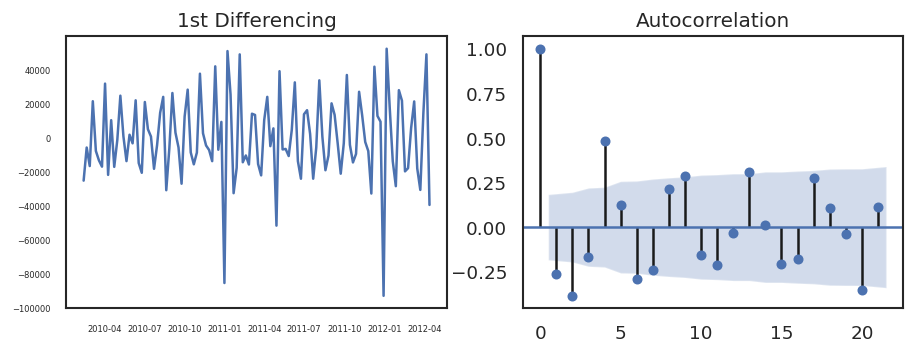

In [0]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)#, sharex=True)
axes[0].plot(modeling_df_train.Weekly_Sales.diff()); axes[0].set_title('1st Differencing')
# axes[0].xaxis.set_major_formatter(ticker.EngFormatter())
axes[0].tick_params(axis='both', which='major', labelsize=5)
plot_acf(modeling_df_train.Weekly_Sales.diff().dropna(), ax=axes[1])

plt.show()

Given the above ACF graph lag 1 is slightly above confidence interval. we can go ahead with q = 0 if we want to be more conservative else q = 1 may work

## SARIMA

With auto_arima, we have a flexibility of trying various combination of (p,d,q) and (P,D,Q) with best AIC value as final model. However the values we found earlier for p,q,d will help us set range for the parameters in auto_arima

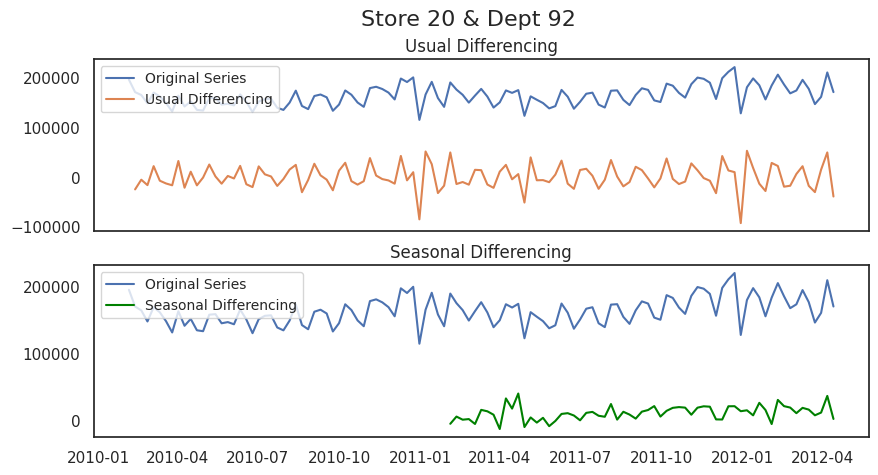

In [0]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(modeling_df_train.Weekly_Sales, label='Original Series')
axes[0].plot(modeling_df_train.Weekly_Sales.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasinal Dei
axes[1].plot(modeling_df_train.Weekly_Sales, label='Original Series')
axes[1].plot(modeling_df_train.Weekly_Sales.diff(52), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Store 20 & Dept 92', fontsize=16)
plt.show()

This shows how differencing with 52 weeks cancels out seasonal effect

In [0]:
!pip3 install pmdarima

     |████████████████████████████████| 1.5MB 7.9MB/s 


In [0]:
modeling_df_Uni = modeling_df_train['Weekly_Sales']
modeling_df_Uni.shape
# modeling_df_test_Uni = modeling_df_test['Weekly_Sales']

(115,)

In [0]:
import pmdarima as pm

smodel = pm.auto_arima(modeling_df_Uni, start_p=0, start_q=0,
                         test='adf',
                         max_p=1, max_q=2, m=52,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 52) (constant=True); AIC=1374.372, BIC=1378.626, Time=0.285 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 52) (constant=True); AIC=1367.718, BIC=1376.227, Time=4.324 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 52) (constant=False); AIC=1372.823, BIC=1374.950, Time=0.534 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 0, 52) (constant=True); AIC=1366.138, BIC=1372.519, Time=0.567 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 52) (constant=True); AIC=1368.820, BIC=1377.329, Time=2.891 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 52) (constant=True); AIC=1370.382, BIC=1376.764, Time=1.044 seconds
Total fit time

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -680.069
Date:                            Thu, 23 Apr 2020   AIC                           1366.138
Time:                                    19:46:55   BIC                           1372.519
Sample:                                         0   HQIC                          1368.644
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    327.7096   1548.999      0.212      0.832   -2708.272    3363.691
ar.L1         -0.2634      0.039     -6.723      0.000      -0.340      -0.187
sigma2      1.659e+08      0.017   9.91e+09      0.000    1.66e+08    1.66e+08
===================================================================================
Ljung-Box (Q):                       40.93   Jarque-Bera (JB):                 5.94
Prob(Q):                              0.43   Prob(JB):                         0.05
Heteroskedasticity (H):               0.73   Skew:                            -0.09
Prob(H) (two-sided):                  0.47   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.69e+28. Standard errors may be unstable.
"""

## Forecast

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-02-10', '2012-02-17', '2012-02-24', '2012-03-02',
               '2012-03-09', '2012-03-16', '2012-03-23', '2012-03-30',
               '2012-04-06', '2012-04-13'],
              dtype='datetime64[ns]', name='Date', length=115, freq=None)
DatetimeIndex(['2012-04-20', '2012-04-27', '2012-05-04', '2012-05-11',
               '2012-05-18', '2012-05-25', '2012-06-01', '2012-06-08',
               '2012-06-15', '2012-06-22', '2012-06-29', '2012-07-06',
               '2012-07-13', '2012-07-20', '2012-07-27', '2012-08-03',
               '2012-08-10', '2012-08-17', '2012-08-24', '2012-08-31',
               '2012-09-07', '2012-09-14', '2012-09-21', '2012-09-28',
               '2012-10-05', '2012-10-12', '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', 

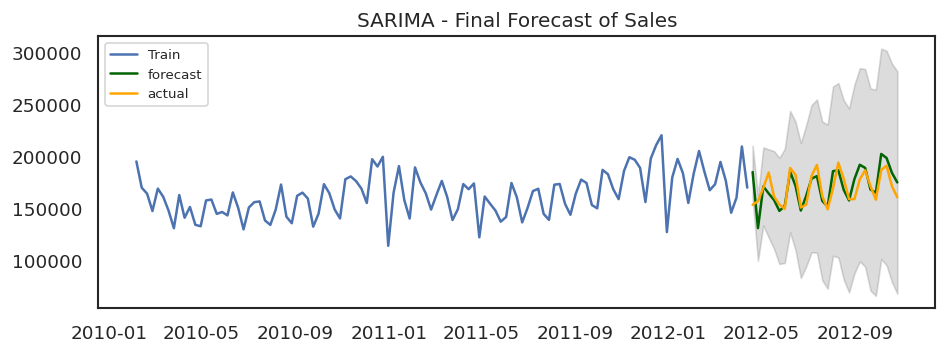

In [0]:
# Forecast
n_periods = len_Val # this variable comes from Train,Val & Test section
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = modeling_df.index[len_train:] #pd.date_range(modeling_df_Uni.index[-1], periods = n_periods, freq='W')
print(modeling_df_Uni.index)
print(index_of_fc)
# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
actual_series = pd.Series(modeling_df_Val.Weekly_Sales.values , modeling_df_Val.index)
# Plot
plt.plot(modeling_df_Uni, label='Train')
plt.plot(fitted_series, color='darkgreen', label='forecast')
plt.plot(actual_series, color='orange', label='actual')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Sales")
plt.legend(loc='upper left', fontsize=8)
plt.show()

AttributeError: ignored

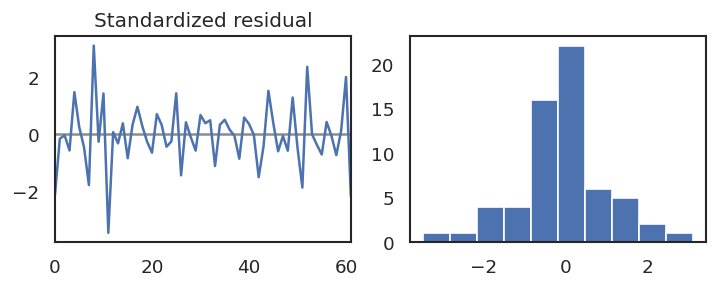

In [0]:
smodel.plot_diagnostics(figsize=(7,5))
plt.show()

## Accuracy

In [0]:
# Accuracy metrics
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fitted_series, actual_series)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'acf1': 0.004673829905252914,
 'corr': 0.7050087283978063,
 'mae': 9562.475731646551,
 'mape': 0.056799696865951876,
 'me': 1529.9595684823673,
 'minmax': 0.05366428845509552,
 'mpe': 0.010345476182379089,
 'rmse': 12241.225618901912}

MAPE value is 5.67%

# Modeling (with Regressor)

## SARIMAX: IsHoliday

In [0]:

import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(modeling_df_train[['Weekly_Sales']], exogenous=modeling_df_train[['IsHoliday']],
                           start_p=0, start_q=0,
                           test='adf',
                           max_p=1, max_q=2, m=52,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=1356.537, BIC=1362.967, Time=0.322 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=1359.538, BIC=1370.253, Time=11.690 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=False); AIC=1595.043, BIC=1599.329, Time=0.246 seconds
Fit ARIMA: (0, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=1358.224, BIC=1366.796, Time=4.517 seconds
Fit ARIMA: (0, 0, 0)x(1, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=1357.552, BIC=1366.125, Time=0.504 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 0, 52) (constant=True); AIC=1357.131, BIC=1365.703, Time=0.991 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 0, 52) (constant=True); AIC=1359.083, BIC=1369.799, Time=1.492 seconds
T

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/mlemodel.py:2060: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                        y   No. Observations:                  115
Model:             SARIMAX(0, 1, 0, 52)   Log Likelihood                -675.269
Date:                  Thu, 23 Apr 2020   AIC                           1356.537
Time:                          20:49:41   BIC                           1362.967
Sample:                      02-05-2010   HQIC                          1359.066
                           - 04-13-2012                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.056e+04   1390.714      7.590      0.000    7829.526    1.33e+04
IsHoliday           0         -0        nan        nan           0           0
sigma2      1.195e+08   2.13e+07      5.621      0.000    7.79e+07    1.61e+08
===================================================================================
Ljung-Box (Q):                       42.03   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.38   Prob(JB):                         0.81
Heteroskedasticity (H):               0.60   Skew:                             0.20
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

We got slightly better AIC in this case. Earlier it was 1366.138 now it is 1356.537. Let's try putting other combination of Regressors

## SARIMAX: Size

In [0]:
sxmodel = pm.auto_arima(modeling_df_train[['Weekly_Sales']], exogenous=modeling_df_train[['Size']],
                           start_p=0, start_q=0,
                           test='adf',
                           max_p=1, max_q=2, m=52,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=1356.537, BIC=1362.967, Time=0.272 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=1357.729, BIC=1368.445, Time=18.821 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=False); AIC=1595.043, BIC=1599.329, Time=0.219 seconds
Fit ARIMA: (0, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=1358.188, BIC=1366.760, Time=27.908 seconds
Fit ARIMA: (0, 0, 0)x(1, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=1356.278, BIC=1364.850, Time=4.549 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 0, 1)x(0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 52)   Log Likelihood                -674.139
Date:                            Thu, 23 Apr 2020   AIC                           1356.278
Time:                                    20:56:49   BIC                           1364.850
Sample:                                02-05-2010   HQIC                          1359.650
                                     - 04-13-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.061e+04   1739.040      6.101      0.000    7202.165     1.4e+04
Size         -73.8955   7887.281     -0.009      0.993   -1.55e+04    1.54e+04
ar.L1         -0.0011      0.107     -0.010      0.992      -0.211       0.209
sigma2      1.171e+08      0.637   1.84e+08      0.000    1.17e+08    1.17e+08
===================================================================================
Ljung-Box (Q):                       37.96   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.56   Prob(JB):                         0.80
Heteroskedasticity (H):               0.64   Skew:                             0.19
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.12e+23. Standard errors may be unstable.
"""

Pretty much same as IsHoliday

## SARIMAX: IsHoliday + Size

In [0]:
sxmodel = pm.auto_arima(modeling_df_train[['Weekly_Sales']], exogenous=modeling_df_train[['IsHoliday','Size']],
                           start_p=0, start_q=0,
                           test='adf',
                           max_p=1, max_q=2, m=52,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=1358.537, BIC=1367.110, Time=0.325 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=1359.729, BIC=1372.588, Time=21.770 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=False); AIC=1597.043, BIC=1603.472, Time=0.257 seconds
Fit ARIMA: (0, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=1360.188, BIC=1370.903, Time=33.431 seconds
Fit ARIMA: (0, 0, 0)x(1, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=1358.278, BIC=1368.994, Time=5.375 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 0, 1)x(0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 52)   Log Likelihood                -674.139
Date:                            Thu, 23 Apr 2020   AIC                           1358.278
Time:                                    21:00:59   BIC                           1368.994
Sample:                                02-05-2010   HQIC                          1362.492
                                     - 04-13-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.061e+04   1739.040      6.101      0.000    7202.165     1.4e+04
IsHoliday           0   4.78e-10          0      1.000   -9.37e-10    9.37e-10
Size         -73.8955   7887.281     -0.009      0.993   -1.55e+04    1.54e+04
ar.L1         -0.0011      0.107     -0.010      0.992      -0.211       0.209
sigma2      1.171e+08      0.637   1.84e+08      0.000    1.17e+08    1.17e+08
===================================================================================
Ljung-Box (Q):                       37.96   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.56   Prob(JB):                         0.80
Heteroskedasticity (H):               0.64   Skew:                             0.19
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.45e+21. Standard errors may be unstable.
"""

All three regressor performed bit better than the model without regressor; with IsHoliday performing slightly better than others. IsHoliday is a direct indicator of seasonality hence contributing towards forecasting efficiency.

Although, if we look closely pvalue is not that significant, hence we shoult not trust results from regressor method 

# Modeling (Store level)

## Create Data

In [0]:
fn = {'Weekly_Sales':['mean'], 'IsHoliday':['first'], 'Size': ['mean']}

#Train Data
model_df_str = train_model_df.groupby(['Date','Store']).agg(fn) # we are taking mean as few stores dont have all departments so total sales will give biased number
model_df_str = model_df_str[model_df_str.index.isin(['14'], level=1)]
model_df_str.columns = model_df_str.columns.droplevel(1)
model_df_str.reset_index(level=1, drop=True, inplace=True)
model_df_str.head() 

,Store,Dept,IsHoliday,Type,Size
Date,,,,,
2012-11-02,14,1,0,A,200898
2012-11-02,14,2,0,A,200898
2012-11-02,14,3,0,A,200898
2012-11-02,14,4,0,A,200898
2012-11-02,14,5,0,A,200898


## Train, Val & Test

In [0]:
import math

len_Total =model_df_str.shape[0]
len_train = math.ceil(0.8*len_Total)
len_Val = len_Total - len_train

modeling_df_str_train = model_df_str.iloc[:len_train]
modeling_df_str_Val = model_df_str.iloc[len_train:]
modeling_df_str_train.head()

,Weekly_Sales,IsHoliday,Size
Date,,,
2010-02-05,36950.280986,0,200898
2010-02-12,23669.706111,0,200898
2010-02-19,30618.843056,0,200898
2010-02-26,29105.439306,0,200898
2010-03-05,31077.010417,0,200898


In [0]:
#Test Data
model_df_str_test = test_model_df[test_model_df['Store']==14]
model_df_str_test.set_index('Date',inplace=True)
model_df_str_test.head()

,Store,Dept,IsHoliday,Type,Size
Date,,,,,
2012-11-02,14,1,0,A,200898
2012-11-02,14,2,0,A,200898
2012-11-02,14,3,0,A,200898
2012-11-02,14,4,0,A,200898
2012-11-02,14,5,0,A,200898


## SARIMA

Not using SARIMAX because the effect of regressors are not significant

In [0]:
import pmdarima as pm

smodel = pm.auto_arima(modeling_df_str_train[['Weekly_Sales']], start_p=0, start_q=0,
                         test='adf',
                         max_p=1, max_q=2, m=52,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 52) (constant=True); AIC=1194.635, BIC=1198.889, Time=0.241 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 52) (constant=True); AIC=1141.789, BIC=1150.297, Time=4.310 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 52) (constant=False); AIC=1192.727, BIC=1194.855, Time=0.501 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 0, 52) (constant=True); AIC=1152.459, BIC=1158.840, Time=0.521 seconds
Fit ARIMA: (1, 1, 0)x(2, 1, 0, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 1, 0)x(2, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 0, 52) (co

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 52)   Log Likelihood                -564.224
Date:                            Thu, 23 Apr 2020   AIC                           1138.449
Time:                                    22:39:43   BIC                           1149.084
Sample:                                         0   HQIC                          1142.624
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -101.6870    226.841     -0.448      0.654    -546.288     342.914
ar.L1         -0.4026      0.150     -2.682      0.007      -0.697      -0.108
ma.L1         -0.2504      0.160     -1.561      0.119      -0.565       0.064
ar.S.L52      -0.2323      0.025     -9.225      0.000      -0.282      -0.183
sigma2      4.341e+06   5.88e+05      7.379      0.000    3.19e+06    5.49e+06
===================================================================================
Ljung-Box (Q):                       31.59   Jarque-Bera (JB):                12.12
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.32
Prob(H) (two-sided):                  0.68   Kurtosis:                         5.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecast

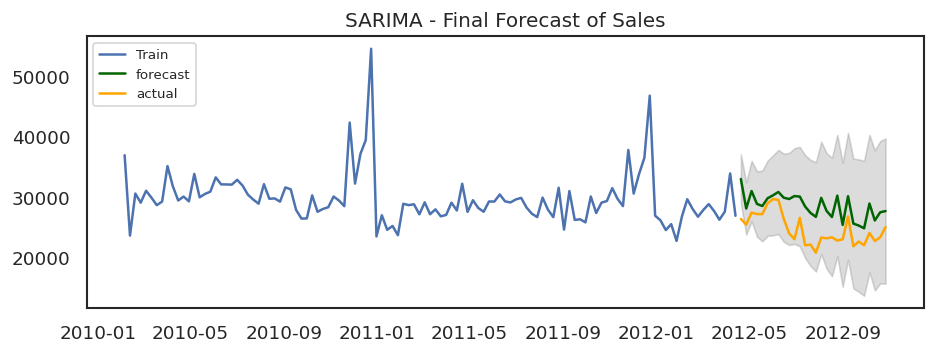

In [0]:
# Forecast
n_periods = len_Val # this variable comes from Train,Val & Test section
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = modeling_df_str_Val.index #pd.date_range(modeling_df_Uni.index[-1], periods = n_periods, freq='W')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
actual_series = pd.Series(modeling_df_str_Val.Weekly_Sales.values , modeling_df_str_Val.index)
# Plot
plt.plot(modeling_df_str_train[['Weekly_Sales']], label='Train')
plt.plot(fitted_series, color='darkgreen', label='forecast')
plt.plot(actual_series, color='orange', label='actual')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Sales")
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Accuracy

In [0]:
# Accuracy metrics
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fitted_series, actual_series)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'acf1': 0.38841258990005545,
 'corr': 0.6532365826775279,
 'mae': 3849.566821759113,
 'mape': 0.16171281492463938,
 'me': 3849.566821759113,
 'minmax': 0.1345137992593558,
 'mpe': 0.16171281492463938,
 'rmse': 4295.350190011232}

MAPE value is 16.17%

# Modeling (Dept level)

## Create Data

In [0]:
fn = {'Weekly_Sales':['mean'], 'IsHoliday':['first']}

#Train Data
model_df_dep = train_model_df.groupby(['Date','Dept']).agg(fn) # we are taking mean as few stores dont have all departments so total sales will give biased number
model_df_dep = model_df_dep[model_df_dep.index.isin(['95'], level=1)]
model_df_dep.columns = model_df_dep.columns.droplevel(1)
model_df_dep.reset_index(level=1, drop=True, inplace=True)
model_df_dep.head() 

,Weekly_Sales,IsHoliday
Date,,
2010-02-05,70456.220667,0
2010-02-12,66136.651333,0
2010-02-19,62534.173111,0
2010-02-26,61986.936222,0
2010-03-05,66540.872000,0


## Train,Val & Test

In [0]:
import math

len_Total =model_df_dep.shape[0]
len_train = math.ceil(0.8*len_Total)
len_Val = len_Total - len_train

modeling_df_dep_train = model_df_dep.iloc[:len_train]
modeling_df_dep_Val = model_df_dep.iloc[len_train:]
modeling_df_dep_train.head()

,Weekly_Sales,IsHoliday
Date,,
2010-02-05,70456.220667,0
2010-02-12,66136.651333,0
2010-02-19,62534.173111,0
2010-02-26,61986.936222,0
2010-03-05,66540.872000,0


## SARIMA

In [0]:
import pmdarima as pm

smodel = pm.auto_arima(modeling_df_dep_train[['Weekly_Sales']], start_p=0, start_q=0,
                         test='adf',
                         max_p=1, max_q=2, m=52,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 52) (constant=True); AIC=1177.972, BIC=1182.226, Time=0.351 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 52) (constant=True); AIC=1173.011, BIC=1181.520, Time=12.275 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 52) (constant=False); AIC=1176.008, BIC=1178.135, Time=0.512 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 0, 52) (constant=True); AIC=1172.245, BIC=1178.626, Time=0.540 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 1, 52) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 52) (constant=True); AIC=1177.169, BIC=1185.677, Time=1.672 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 52) (constant=True); AIC=1175.471, BIC=1181.852, Time=0.988 seconds
Total fit tim

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -583.122
Date:                            Thu, 23 Apr 2020   AIC                           1172.245
Time:                                    23:11:20   BIC                           1178.626
Sample:                                         0   HQIC                          1174.750
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     48.8346    300.311      0.163      0.871    -539.763     637.433
ar.L1         -0.1703      0.029     -5.785      0.000      -0.228      -0.113
sigma2      6.835e+06   8.81e+05      7.757      0.000    5.11e+06    8.56e+06
===================================================================================
Ljung-Box (Q):                       53.21   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.08   Prob(JB):                         0.39
Heteroskedasticity (H):               0.71   Skew:                             0.17
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecast

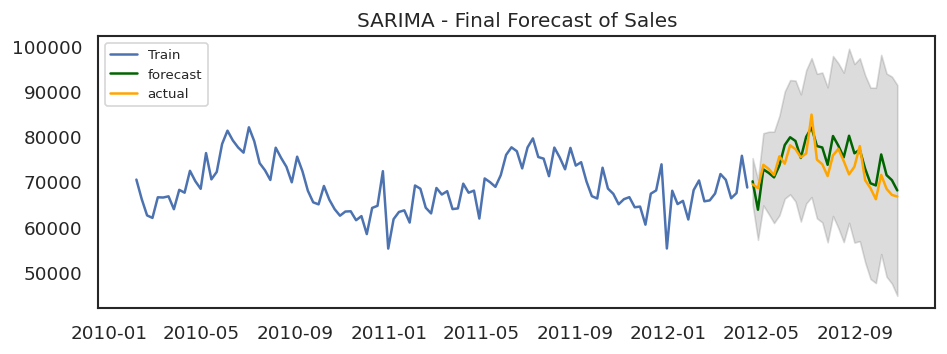

In [0]:
# Forecast
n_periods = len_Val # this variable comes from Train,Val & Test section
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = modeling_df_dep_Val.index #pd.date_range(modeling_df_Uni.index[-1], periods = n_periods, freq='W')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
actual_series = pd.Series(modeling_df_dep_Val.Weekly_Sales.values , modeling_df_dep_Val.index)
# Plot
plt.plot(modeling_df_dep_train[['Weekly_Sales']], label='Train')
plt.plot(fitted_series, color='darkgreen', label='forecast')
plt.plot(actual_series, color='orange', label='actual')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Sales")
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Accuracy

In [0]:
# Accuracy metrics
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fitted_series, actual_series)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'acf1': 0.13738668786162941,
 'corr': 0.8095272568674788,
 'mae': 2512.8672267810716,
 'mape': 0.034657236605049734,
 'me': 1586.2843170313092,
 'minmax': 0.03320187743475855,
 'mpe': 0.022171468083617866,
 'rmse': 3073.178558476027}

MAPE value is 3%

# Predictive Modeling on Time Series

## Data Creation

In [5]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
features_df = pd.read_csv("/content/drive/My Drive/DMBI_Proj/Data/features.csv",parse_dates=['Date'],date_parser=dateparse)
stores_df = pd.read_csv("/content/drive/My Drive/DMBI_Proj/Data/stores.csv")
test_df = pd.read_csv("/content/drive/My Drive/DMBI_Proj/Data/test.csv",parse_dates=['Date'], date_parser=dateparse)
train_df = pd.read_csv("/content/drive/My Drive/DMBI_Proj/Data/train.csv",parse_dates=['Date'],date_parser=dateparse)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In [12]:
df_Merged=pd.merge(train_df,features_df,on=['Store','Date','IsHoliday'],how='inner')
df_Merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [11]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [13]:
df_Merged=pd.merge(df_Merged,stores_df,on='Store',how='left')
df_Merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


We need to impute values of Markdown if we want to use it as we saw that around 65-70% of the data is missing

In [0]:
from sklearn.impute import SimpleImputer

markdown=pd.DataFrame(SimpleImputer().fit_transform(df_Merged[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]),columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
df_Merged = df_Merged.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis=1)
df_Merged=pd.concat([df_Merged,markdown],axis=1)

Checking id we have date varibale as date type

In [15]:
df_Merged.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
dtype: object

Creating Year, month and day column from date to be used in modeling

In [0]:
df_Merged['year']=df_Merged['Date'].dt.year
df_Merged['month']=df_Merged['Date'].dt.month
df_Merged['day']=df_Merged['Date'].dt.day
del df_Merged['Date']

Need to convert variable type into ordinal or binary

In [17]:
from sklearn.preprocessing import LabelEncoder

df_Merged['Type']=LabelEncoder().fit_transform(df_Merged['Type'])
df_Merged['IsHoliday']=LabelEncoder().fit_transform(df_Merged['IsHoliday'])
df_Merged.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday         int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Type              int64
Size              int64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
year              int64
month             int64
day               int64
dtype: object

## Train-Val-Test Split

In [0]:
from scipy.stats import zscore 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Standardizing the data and splitting the data into train and test for building the model

In [0]:
X = df_Merged.drop('Weekly_Sales',axis=1)
y = df_Merged['Weekly_Sales']
X_scaled = X.apply(zscore)

X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.3,random_state=34)

Building different models to choose the best fit model with better accuracy

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

lr = LinearRegression()
dt= DecisionTreeRegressor()
rf = RandomForestRegressor()
models = [lr,dt,rf]

for model in models:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(r2_score(y_test,y_pred))

0.08508385525415985
0.948285191188676
0.971198397829188


Decision Tree and Random Forest have a lot better R2 than Linear Regression

Checking the feature importance on Random Forest for hyperparameter tuning to get the best model with best parameters

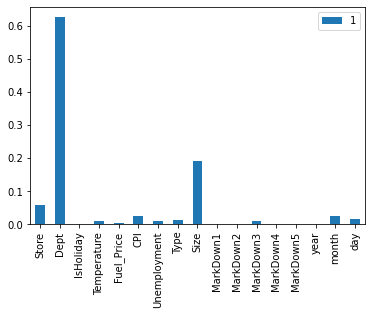

In [23]:
(pd.DataFrame([X.columns,rf.feature_importances_],columns=['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'Type', 'Size', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'year', 'month', 'day']).T).plot.bar()

From the above bar plot, we can observed that Department have high importance compared to other features. Size and Store are next importance features.

Dropping the least importance feature and building the model again

In [24]:
pd.DataFrame([X.columns,rf.feature_importances_],columns=['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'Type', 'Size', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'year', 'month', 'day']).T

,0,1
Store,Store,0.0582985
Dept,Dept,0.62591
IsHoliday,IsHoliday,0.00226424
Temperature,Temperature,0.0101008
Fuel_Price,Fuel_Price,0.00478133
CPI,CPI,0.0256281
Unemployment,Unemployment,0.0101421
Type,Type,0.0144646
Size,Size,0.190921
MarkDown1,MarkDown1,0.00158448


In [0]:
x1 = X_scaled.drop(['IsHoliday','year','MarkDown5','MarkDown4','MarkDown1','MarkDown2'],axis=1)

In [26]:
X_train,X_test,y_train,y_test = train_test_split(x1,y,test_size=.3,random_state=34)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
r2_score(y_test,y_pred)

0.9713437275801682